In [4]:
import wandb
wandb.login()

wandb: Currently logged in as: johnwilsonlorin1 (johnwilsonlorin1-laguna-state-polytechnic-university). Use `wandb login --relogin` to force relogin


True

Total number of rows: 948
Correlation with Phytoplankton (cells/ml):
pH (units)                     0.179615
BOD (mg/l)                     0.172329
Humidity                       0.164101
Wind Speed                     0.158755
Ammonia (mg/L)                 0.153525
Inorganic Phosphate (mg/L)     0.129696
Total coliforms (MPN/100ml)    0.059085
Temperature                    0.030184
Name: Phytoplankton (cells/ml), dtype: float64


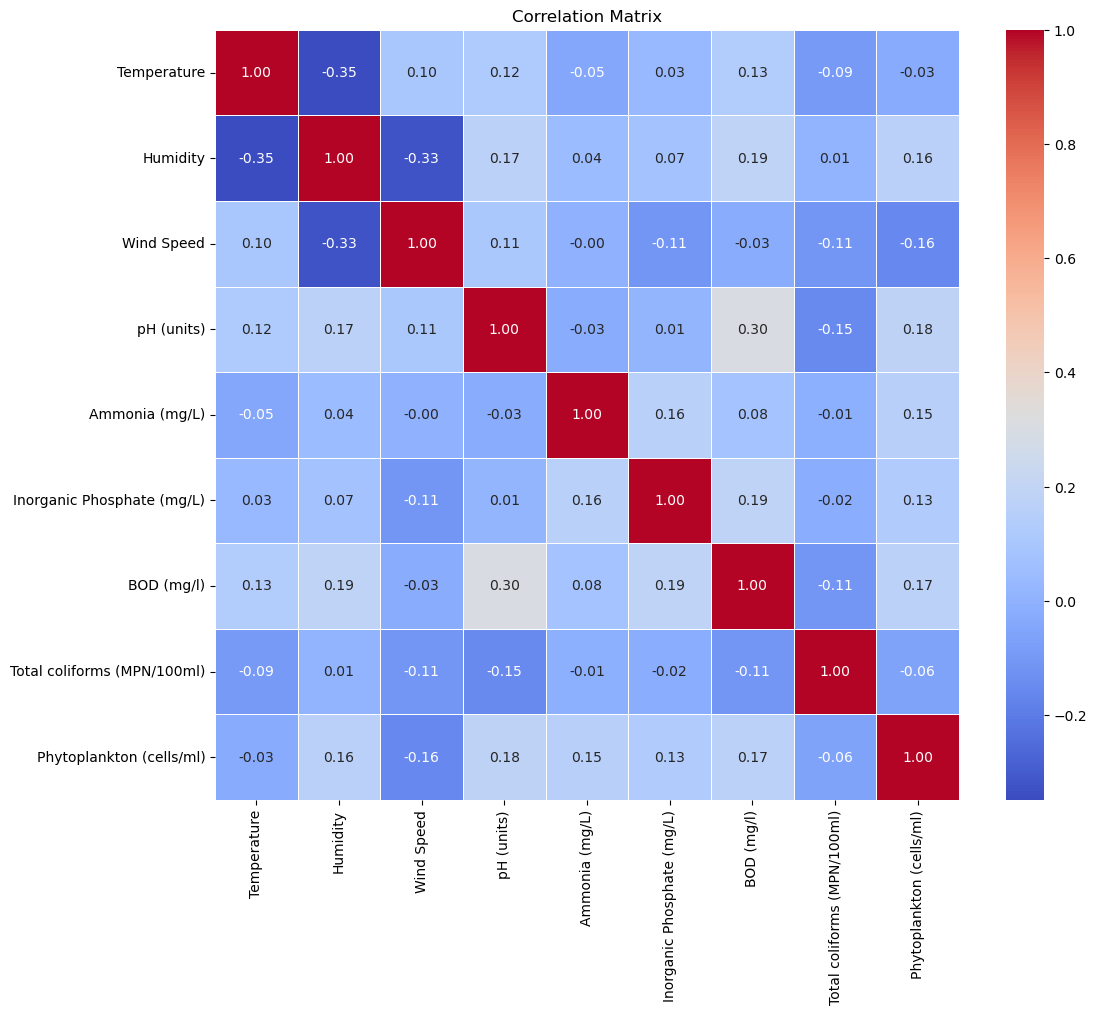

XGBoost - Mean Squared Error: 4553607876.607284
XGBoost - Mean Absolute Error: 36564.18767138029
XGBoost - R^2 Score: 0.7073213855221261


MAE,▁
MSE,▁
R2 Score,▁
MAE,36564.18767
MSE,4553607876.60728
R2 Score,0.70732


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
import wandb

# Initialize a new wandb run
wandb.init(project='LLDA-Detecting Algal Blooms and Fish Kill', name = "XGBRegressor with MICE Imputation(phyto)")

# Load datasets with specified encoding
merged_df = pd.read_csv('Complete_MICE_Imputed.csv')
merged_df = merged_df.dropna()
row_count = len(merged_df)
print(f'Total number of rows: {row_count}')

# Select relevant features and target
features = ['Temperature', 'Humidity', 'Wind Speed', 'pH (units)', 'Ammonia (mg/L)', 'Inorganic Phosphate (mg/L)', 'BOD (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'

# Combine features and target for correlation analysis
df_for_corr = merged_df[features + [target]]

# Calculate correlation matrix
corr_matrix = df_for_corr.corr()

# Print the correlation values with the target variable
target_corr = corr_matrix[target].drop(target)
sorted_target_corr = target_corr.abs().sort_values(ascending=False)

print("Correlation with Phytoplankton (cells/ml):")
print(sorted_target_corr)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Drop any remaining missing values
merged_df = merged_df.dropna()

# Split data into training and testing sets
X = merged_df[features]
y = merged_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Gradient Boosting Machine (XGBoost)
xgb_model = XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Mean Squared Error: {mse_xgb}')
print(f'XGBoost - Mean Absolute Error: {mae_xgb}')
print(f'XGBoost - R^2 Score: {r2_xgb}')

# Log hyperparameters and metrics to wandb
wandb.log({
    'MSE': mse_xgb,
    'MAE': mae_xgb,
    'R2 Score': r2_xgb
})

# Finish the wandb run
wandb.finish()


In [11]:
import pickle
# Save the trained model to a file using pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

print("Model saved to 'xgb_model.pkl'")

# Example: Loading and using the saved model
# Load the model from the file
with open('xgb_model.pkl', 'rb') as file:
    loaded_svr_model = pickle.load(file)

# Predict using the loaded model
y_pred_loaded_model = loaded_svr_model.predict(X_test_scaled)

# Evaluate predictions (if necessary)
mse_loaded_model = mean_squared_error(y_test, y_pred_loaded_model)
mae_loaded_model = mean_absolute_error(y_test, y_pred_loaded_model)
r2_loaded_model = r2_score(y_test, y_pred_loaded_model)

print(f'Loaded Model - Mean Squared Error: {mse_loaded_model}')
print(f'Loaded Model - Mean Absolute Error: {mae_loaded_model}')
print(f'Loaded Model - R^2 Score: {r2_loaded_model}')

Model saved to 'xgb_model.pkl'
Loaded Model - Mean Squared Error: 2969763693.393832
Loaded Model - Mean Absolute Error: 31160.81449312152
Loaded Model - R^2 Score: 0.617278300770117


In [13]:
with open('xgb_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# With Grid Search

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
from xgboost import XGBRegressor
import wandb

# Load dataset
merged_df = pd.read_csv('Complete_MICE_Imputed.csv')
merged_df = merged_df.dropna()

# Select relevant features and target
features = ['Temperature', 'Humidity', 'Wind Speed', 'pH (units)', 'Ammonia (mg/L)', 'Inorganic Phosphate (mg/L)', 'BOD (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'

# Split data into features (X) and target (y)
X = merged_df[features]
y = merged_df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'alpha': [0, 0.1, 0.5],  # L1 regularization
    'lambda': [1, 1.5, 2]    # L2 regularization
}

# Initialize the XGBoost model
xgb_model = XGBRegressor()

# Perform Grid Search Cross-Validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best model after hyperparameter tuning
best_xgb = grid_search.best_estimator_

# Fit the best model on the training data
best_xgb.fit(X_train_scaled, y_train)

# Make predictions with the tuned model
y_pred_xgb_tuned = best_xgb.predict(X_test_scaled)

# Calculate evaluation metrics
mse_xgb_tuned = mean_squared_error(y_test, y_pred_xgb_tuned)
rmse_xgb_tuned = mean_squared_error(y_test, y_pred_xgb_tuned, squared=False)  # RMSE
mae_xgb_tuned = mean_absolute_error(y_test, y_pred_xgb_tuned)
mape_xgb_tuned = mean_absolute_percentage_error(y_test, y_pred_xgb_tuned)  # MAPE
r2_xgb_tuned = r2_score(y_test, y_pred_xgb_tuned)
explained_variance = explained_variance_score(y_test, y_pred_xgb_tuned)  # Explained Variance Score

# Print the tuned model performance
print(f'Tuned XGBoost - Mean Squared Error (MSE): {mse_xgb_tuned}')
print(f'Tuned XGBoost - Root Mean Squared Error (RMSE): {rmse_xgb_tuned}')
print(f'Tuned XGBoost - Mean Absolute Error (MAE): {mae_xgb_tuned}')
print(f'Tuned XGBoost - Mean Absolute Percentage Error (MAPE): {mape_xgb_tuned}')
print(f'Tuned XGBoost - R^2 Score: {r2_xgb_tuned}')
print(f'Tuned XGBoost - Explained Variance Score: {explained_variance}')


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


E:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Tuned XGBoost - Mean Squared Error (MSE): 4750472531.364605
Tuned XGBoost - Root Mean Squared Error (RMSE): 68923.67177802272
Tuned XGBoost - Mean Absolute Error (MAE): 38158.233733167144
Tuned XGBoost - Mean Absolute Percentage Error (MAPE): 7.94128697254241
Tuned XGBoost - R^2 Score: 0.6946681057590547
Tuned XGBoost - Explained Variance Score: 0.6972588343642654


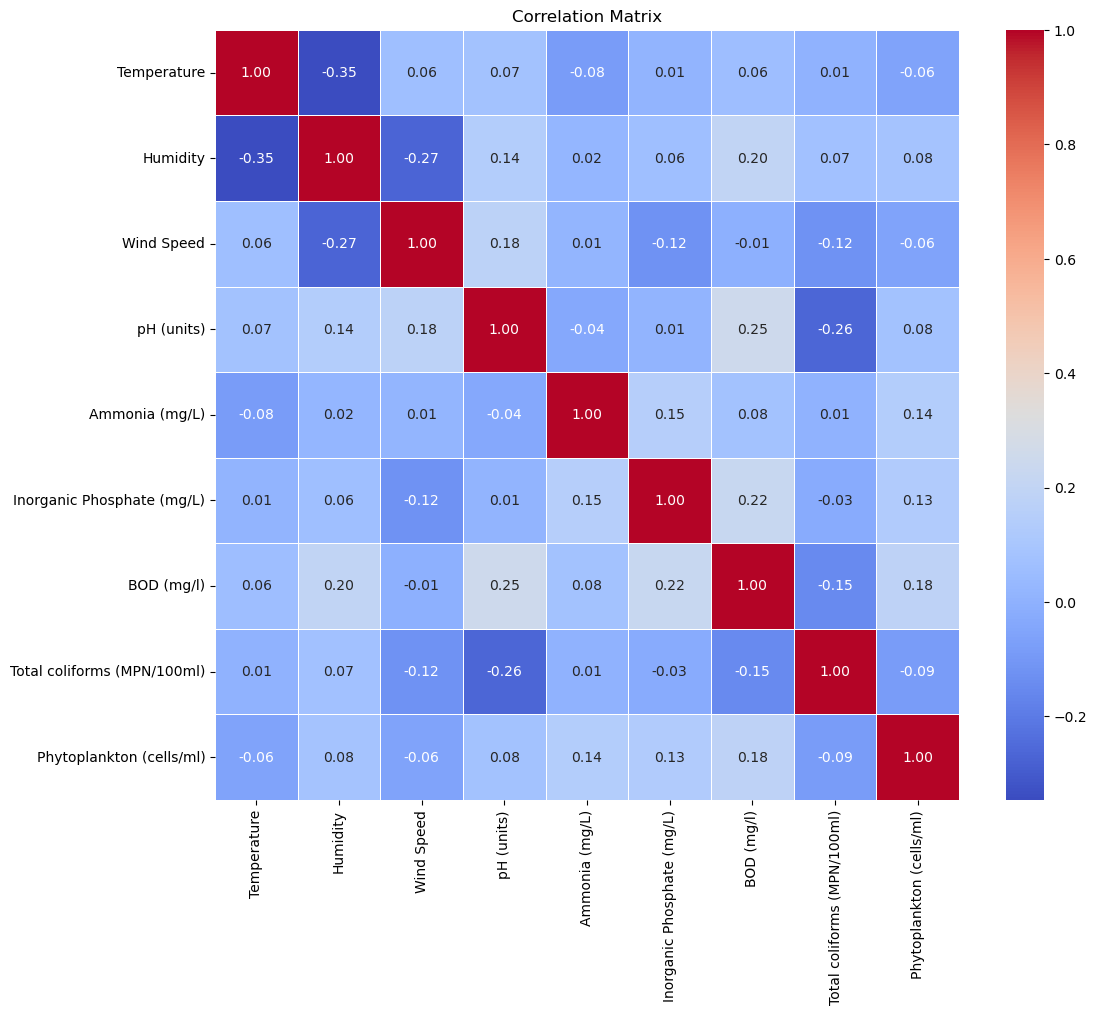

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
XGBoost - Mean Squared Error: 3144098621.918297
XGBoost - Mean Absolute Error: 31430.30487060547
XGBoost - R^2 Score: 0.5948112741078866


MAE,▁
MSE,▁
R2 Score,▁
MAE,31430.30487
MSE,3144098621.9183
R2 Score,0.59481


In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import wandb
import numpy as np

# Initialize a new wandb run
wandb.init(project='LLDA-Detecting Algal Blooms and Fish Kill', name="XGBRegressor with Tuning(Dropped)")

# Load datasets with specified encoding
merged_df = pd.read_csv('Complete.csv')
merged_df = merged_df.dropna()

# Select relevant features and target
features = ['Temperature', 'Humidity', 'Wind Speed', 'pH (units)', 'Ammonia (mg/L)', 'Inorganic Phosphate (mg/L)', 'BOD (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'

# Combine features and target for correlation analysis
df_for_corr = merged_df[features + [target]]

# Calculate correlation matrix
corr_matrix = df_for_corr.corr()
sorted_target_corr = corr_matrix[target].abs().sort_values(ascending=False)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Drop any remaining missing values
merged_df = merged_df.dropna()

# Split data into training and testing sets
X = merged_df[features]
y = merged_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'alpha': [0, 0.1, 0.5],  # L1 regularization
    'lambda': [1, 1.5, 2]    # L2 regularization
}

xgb_model = XGBRegressor()

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best estimator
best_xgb = grid_search.best_estimator_

# Train the best model (early stopping removed)
best_xgb.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Mean Squared Error: {mse_xgb}')
print(f'XGBoost - Mean Absolute Error: {mae_xgb}')
print(f'XGBoost - R^2 Score: {r2_xgb}')

# Log hyperparameters and metrics to wandb
wandb.log({
    'Best Parameters': grid_search.best_params_,
    'MSE': mse_xgb,
    'MAE': mae_xgb,
    'R2 Score': r2_xgb
})

# Finish the wandb run
wandb.finish()


# Tuning

In [18]:
import wandb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the sweep configuration
sweep_config = {
    'method': 'random',  # Using random search for flexibility
    'metric': {'name': 'MSE', 'goal': 'minimize'},  # Optimize for Mean Squared Error
    'parameters': {
        # Focused ranges based on importance
        'colsample_bytree': {'min': 0.6, 'max': 0.9},  # Narrow range with finer steps
        'subsample': {'min': 0.6, 'max': 0.9},  # Focus around optimal values found
        'learning_rate': {'min': 0.05, 'max': 0.15},  # Reduced range to explore smaller steps
        'reg_lambda': {'min': 0.8, 'max': 2.5},  # Adjusted range based on correlation insights
        # Keeping wider ranges for less influential parameters but with fewer tested values
        'alpha': {'min': 0.0, 'max': 0.3},
        'max_depth': {'values': [3, 5, 7]},  # Reduced to key tested depths
        'n_estimators': {'values': [100, 200, 300]}  # More focused range based on optimal performance
    }
}
# Initialize the sweep (remove the 'name' argument)
sweep_id = wandb.sweep(sweep_config, project='LLDA-Detecting Algal Blooms and Fish Kill')

# Training function to be called by the sweep agent
def train():
    # Initialize a new run
    wandb.init()

    # Load dataset
    merged_df = pd.read_csv('Complete_MICE_Imputed.csv')
    merged_df = merged_df.dropna()

    # Select relevant features and target
    features = ['Temperature', 'Humidity', 'Wind Speed', 'pH (units)', 'Ammonia (mg/L)', 'Inorganic Phosphate (mg/L)', 'BOD (mg/l)', 'Total coliforms (MPN/100ml)']
    target = 'Phytoplankton (cells/ml)'

    # Split data into training and testing sets
    X = merged_df[features]
    y = merged_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fetch hyperparameters from wandb config
    config = wandb.config

    # Initialize XGBoost model with hyperparameters from the sweep configuration
    xgb_model = XGBRegressor(
        learning_rate=config.learning_rate,
        n_estimators=config.n_estimators,
        max_depth=config.max_depth,
        subsample=config.subsample,
        colsample_bytree=config.colsample_bytree,
        alpha=config.alpha,
        reg_lambda=config.reg_lambda
    )

    # Train the model
    xgb_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_xgb = xgb_model.predict(X_test_scaled)

    # Calculate evaluation metrics
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)

    # Log metrics to wandb
    wandb.log({
        'Sweep_MSE': mse_xgb,
        'Sweep_MAE': mae_xgb,
        'Sweep_R2 Score': r2_xgb
    })

    # Finish the run
    wandb.finish()

# Run the sweep agent to execute the sweep
wandb.agent(sweep_id, function=train, count=20)  # Adjust count based on the number of runs you want to perform


Create sweep with ID: v37y6lyj
Sweep URL: https://wandb.ai/johnwilsonlorin1-laguna-state-polytechnic-university/LLDA-Detecting%20Algal%20Blooms%20and%20Fish%20Kill/sweeps/v37y6lyj


wandb: Agent Starting Run: jb78u29h with config:
wandb: 	alpha: 0.4649584713989878
wandb: 	colsample_bytree: 0.9252120498650744
wandb: 	learning_rate: 0.13386926321533135
wandb: 	max_depth: 5
wandb: 	n_estimators: 200
wandb: 	reg_lambda: 1.935779277054266
wandb: 	subsample: 0.9320707720466004


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,38964.94047
Sweep_MSE,4651143910.60318
Sweep_R2 Score,0.70105


wandb: Agent Starting Run: 0lh0bx4r with config:
wandb: 	alpha: 0.16261335500964824
wandb: 	colsample_bytree: 0.778773692984368
wandb: 	learning_rate: 0.13995211225204468
wandb: 	max_depth: 7
wandb: 	n_estimators: 500
wandb: 	reg_lambda: 1.4013611885851915
wandb: 	subsample: 0.9822302596228788


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,36683.31241
Sweep_MSE,4444115906.96995
Sweep_R2 Score,0.71436


wandb: Agent Starting Run: ucwtajt0 with config:
wandb: 	alpha: 0.3639993954036478
wandb: 	colsample_bytree: 0.7570591126238316
wandb: 	learning_rate: 0.08966019269775174
wandb: 	max_depth: 3
wandb: 	n_estimators: 200
wandb: 	reg_lambda: 1.659517606373523
wandb: 	subsample: 0.7885820239283724


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,40120.28496
Sweep_MSE,5092111870.58022
Sweep_R2 Score,0.67271


wandb: Agent Starting Run: vofoe50w with config:
wandb: 	alpha: 0.42549923630607056
wandb: 	colsample_bytree: 0.8973572125024696
wandb: 	learning_rate: 0.10310010457827068
wandb: 	max_depth: 5
wandb: 	n_estimators: 100
wandb: 	reg_lambda: 1.6127729899863548
wandb: 	subsample: 0.7688275584955562


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,39485.99817
Sweep_MSE,5005798901.01345
Sweep_R2 Score,0.67826


wandb: Agent Starting Run: yb7j5i28 with config:
wandb: 	alpha: 0.1661684339549403
wandb: 	colsample_bytree: 0.8527157803737424
wandb: 	learning_rate: 0.16478522390848557
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	reg_lambda: 1.7644463539372373
wandb: 	subsample: 0.8712208101451874


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,39595.93437
Sweep_MSE,4962761859.97236
Sweep_R2 Score,0.68102


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6a6exzjy with config:
wandb: 	alpha: 0.2545541109768857
wandb: 	colsample_bytree: 0.8378201156896883
wandb: 	learning_rate: 0.1580090162357509
wandb: 	max_depth: 5
wandb: 	n_estimators: 200
wandb: 	reg_lambda: 1.1320778962939515
wandb: 	subsample: 0.9178004529460196


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,36681.21856
Sweep_MSE,4452019071.19126
Sweep_R2 Score,0.71385


wandb: Agent Starting Run: 3m96uwrh with config:
wandb: 	alpha: 0.3991367435483428
wandb: 	colsample_bytree: 0.7715748531960231
wandb: 	learning_rate: 0.11823369577057603
wandb: 	max_depth: 5
wandb: 	n_estimators: 200
wandb: 	reg_lambda: 1.1218880631728512
wandb: 	subsample: 0.7938305379482433


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,40980.73692
Sweep_MSE,5161676343.90768
Sweep_R2 Score,0.66824


wandb: Agent Starting Run: o5q8xizv with config:
wandb: 	alpha: 0.23429592376204864
wandb: 	colsample_bytree: 0.7837511345020055
wandb: 	learning_rate: 0.14079465374192546
wandb: 	max_depth: 3
wandb: 	n_estimators: 500
wandb: 	reg_lambda: 1.0210488899707666
wandb: 	subsample: 0.8486324262709611


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,42067.66719
Sweep_MSE,5152685396.07409
Sweep_R2 Score,0.66882


wandb: Agent Starting Run: cio0jt4r with config:
wandb: 	alpha: 0.08946554974737164
wandb: 	colsample_bytree: 0.7035476392845377
wandb: 	learning_rate: 0.1376807404691462
wandb: 	max_depth: 7
wandb: 	n_estimators: 200
wandb: 	reg_lambda: 1.1739360736432003
wandb: 	subsample: 0.7869884743911315


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,41484.1013
Sweep_MSE,5826729492.9359
Sweep_R2 Score,0.62549


wandb: Agent Starting Run: rsx85k4l with config:
wandb: 	alpha: 0.1386240457672725
wandb: 	colsample_bytree: 0.8189195377063712
wandb: 	learning_rate: 0.05773282763950268
wandb: 	max_depth: 3
wandb: 	n_estimators: 100
wandb: 	reg_lambda: 1.8814037994233332
wandb: 	subsample: 0.8038830733216411


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,41611.80051
Sweep_MSE,5452180460.93666
Sweep_R2 Score,0.64957


wandb: Agent Starting Run: mrsh6bwc with config:
wandb: 	alpha: 0.3721457283862062
wandb: 	colsample_bytree: 0.720545835954666
wandb: 	learning_rate: 0.07504800041995667
wandb: 	max_depth: 7
wandb: 	n_estimators: 500
wandb: 	reg_lambda: 1.6732161374152192
wandb: 	subsample: 0.7805519727887856


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,40645.17286
Sweep_MSE,5353873065.05643
Sweep_R2 Score,0.65589


wandb: Agent Starting Run: rhqnz4m1 with config:
wandb: 	alpha: 0.47420640049795654
wandb: 	colsample_bytree: 0.8805661939161966
wandb: 	learning_rate: 0.07029258649975935
wandb: 	max_depth: 3
wandb: 	n_estimators: 100
wandb: 	reg_lambda: 1.580727662971336
wandb: 	subsample: 0.7925131468541764


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,42069.32168
Sweep_MSE,5258877535.37305
Sweep_R2 Score,0.66199


wandb: Agent Starting Run: e02ihkxw with config:
wandb: 	alpha: 0.2751114486209825
wandb: 	colsample_bytree: 0.9088652794501808
wandb: 	learning_rate: 0.10724151775185124
wandb: 	max_depth: 7
wandb: 	n_estimators: 200
wandb: 	reg_lambda: 1.9933879356743816
wandb: 	subsample: 0.8808281088381115


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,38723.33802
Sweep_MSE,4955640983.54254
Sweep_R2 Score,0.68148


wandb: Agent Starting Run: d086xskd with config:
wandb: 	alpha: 0.23296367561292047
wandb: 	colsample_bytree: 0.9492254252549625
wandb: 	learning_rate: 0.047376762075898186
wandb: 	max_depth: 3
wandb: 	n_estimators: 100
wandb: 	reg_lambda: 1.2715849535105883
wandb: 	subsample: 0.7742764987322149


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,42319.25839
Sweep_MSE,5437168033.10398
Sweep_R2 Score,0.65053


wandb: Agent Starting Run: kb3zlh1c with config:
wandb: 	alpha: 0.07423272726712321
wandb: 	colsample_bytree: 0.9389214992042494
wandb: 	learning_rate: 0.06686821239906865
wandb: 	max_depth: 7
wandb: 	n_estimators: 100
wandb: 	reg_lambda: 1.341744668711609
wandb: 	subsample: 0.7477916827434558


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,37709.37281
Sweep_MSE,4688297235.33024
Sweep_R2 Score,0.69866


wandb: Agent Starting Run: vu7amvpk with config:
wandb: 	alpha: 0.10363014224105892
wandb: 	colsample_bytree: 0.7855054346622281
wandb: 	learning_rate: 0.12878251684984507
wandb: 	max_depth: 5
wandb: 	n_estimators: 100
wandb: 	reg_lambda: 1.3276562061856836
wandb: 	subsample: 0.8173656165312515


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,40452.18981
Sweep_MSE,5116668347.44826
Sweep_R2 Score,0.67113


wandb: Agent Starting Run: qh181ztq with config:
wandb: 	alpha: 0.09583632848552807
wandb: 	colsample_bytree: 0.7860589238856536
wandb: 	learning_rate: 0.10388638867901064
wandb: 	max_depth: 7
wandb: 	n_estimators: 200
wandb: 	reg_lambda: 1.8131362823933843
wandb: 	subsample: 0.831484940283856


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,39330.46942
Sweep_MSE,4926144438.72294
Sweep_R2 Score,0.68338


wandb: Agent Starting Run: sxwiz0ey with config:
wandb: 	alpha: 0.3610065638030662
wandb: 	colsample_bytree: 0.9338046438868786
wandb: 	learning_rate: 0.06747595352423265
wandb: 	max_depth: 3
wandb: 	n_estimators: 500
wandb: 	reg_lambda: 1.773270088028115
wandb: 	subsample: 0.9207411936282272


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,41469.75
Sweep_MSE,5066092697.23362
Sweep_R2 Score,0.67438


wandb: Agent Starting Run: v62cgn22 with config:
wandb: 	alpha: 0.2461528565619288
wandb: 	colsample_bytree: 0.9991579637113336
wandb: 	learning_rate: 0.07033084333818519
wandb: 	max_depth: 5
wandb: 	n_estimators: 100
wandb: 	reg_lambda: 1.6616811396132496
wandb: 	subsample: 0.7508401396761398


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,37873.90694
Sweep_MSE,4720827873.11151
Sweep_R2 Score,0.69657


wandb: Agent Starting Run: wfgxl58s with config:
wandb: 	alpha: 0.12425169636421655
wandb: 	colsample_bytree: 0.8456592942165526
wandb: 	learning_rate: 0.09077286645815032
wandb: 	max_depth: 3
wandb: 	n_estimators: 200
wandb: 	reg_lambda: 1.7059716499417437
wandb: 	subsample: 0.8075196657341426


Sweep_MAE,▁
Sweep_MSE,▁
Sweep_R2 Score,▁
Sweep_MAE,40871.15053
Sweep_MSE,5265809400.86517
Sweep_R2 Score,0.66155
